# Crack detection in concrete

## Importing necessary libraries

In [3]:
import pandas as pd
import os
import random
import cv2
from matplotlib import pyplot as plt
import splitfolders
import numpy as np
from torchsummary import summary
from torch import nn
import copy
import time

## Loading the dataset

In [4]:
positive_dataset_path = './Concrete Crack Images for Classification/Positive/'
negative_dataset_path = './Concrete Crack Images for Classification/Negative/'
dataset_path = "Concrete Crack Images for Classification"

In [5]:
pos_images = os.listdir(positive_dataset_path)
neg_images = os.listdir(negative_dataset_path)

Number of images with cracks: 20000
Number of images without crack: 20000
Image with a crack


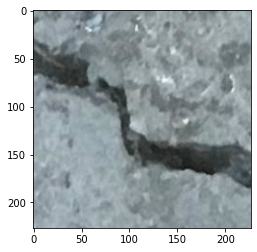

Image without a crack


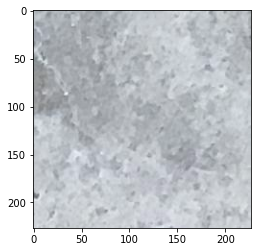

In [6]:
print('Number of images with cracks:', len(pos_images))
print('Number of images without crack:', len(neg_images))
pos_path = pos_images[random.randint(0,len(pos_images))]
rand_pos_img = cv2.imread(f'{positive_dataset_path}{pos_path}')
neg_path = neg_images[random.randint(0,len(neg_images))]
rand_neg_img = cv2.imread(f'{negative_dataset_path}{neg_path}')
print("Image with a crack")
plt.imshow(rand_pos_img)
plt.show()
print("Image without a crack")
plt.imshow(rand_neg_img)
plt.show()

### Divide into train, test and validation

In [7]:
root_dir = 'Images'
pos_dir = 'Positive'
neg_dir = 'Negative'

In [8]:
def split_data():
    splitfolders.ratio(input=dataset_path, output=root_dir, seed=1337, ratio=(.7, .15, .15), group_prefix=None )
# split_data()

In [9]:
train_pos = os.listdir(f'{root_dir}/train/{pos_dir}')
train_neg = os.listdir(f'{root_dir}/train/{neg_dir}')
val_pos = os.listdir(f'{root_dir}/val/{pos_dir}')
val_neg = os.listdir(f'{root_dir}/val/{neg_dir}')
test_pos = os.listdir(f'{root_dir}/test/{pos_dir}')
test_neg = os.listdir(f'{root_dir}/test/{neg_dir}')


In [10]:
print("Number of train positive: ", len(train_pos))
print("Number of train neg: ", len(train_neg))
print("Number of val positive: ", len(val_pos))
print("Number of val neg: ", len(val_neg))
print("Number of test positive: ", len(test_pos))
print("Number of test neg: ", len(test_neg))

Number of train positive:  14001
Number of train neg:  14001
Number of val positive:  3001
Number of val neg:  3001
Number of test positive:  3000
Number of test neg:  3000


## Dataloader and transform

In [11]:
import timm
import torch
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [12]:
BATCH_SIZE = 256

In [13]:
data_transformer = {'train': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
]), 'val': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])}

In [14]:
def get_dataset(root_dir, mode):
    path = os.path.join(root_dir, mode)
    transformer = None if mode == "test" else data_transformer[mode]
    dataset = datasets.ImageFolder(
        root = path,
        transform = transformer
    )
    return dataset


In [15]:
d = get_dataset('fewerImages/', 'val')
d

Dataset ImageFolder
    Number of datapoints: 133
    Root location: fewerImages/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [16]:
def dataloader(root_dir, mode):
    dataset = get_dataset(root_dir, mode)
    # Can have batchsize in dataloader
    data_loader = DataLoader(
        dataset,
        batch_size = BATCH_SIZE,
        shuffle =True
    )
    return data_loader, dataset

In [17]:
dataloder_train, dataset_train = dataloader(root_dir, "train")
dataloader_val, dataset_val = dataloader(root_dir, "val")

In [18]:
dataloader_val

In [19]:
dataloder_train

In [20]:
print(f"Length of dataset: {len(dataset_train)}, classes in dataset: {dataset_train.classes}")
inputs, classes = next(iter(dataloder_train))
print("Shape of image:", inputs.shape)

Length of dataset: 28000, classes in dataset: ['Negative', 'Positive']
Shape of image: torch.Size([256, 3, 224, 224])


In [21]:
print(classes[0])

tensor(0)


In [22]:
classes

tensor([0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

### Function for visualizing images

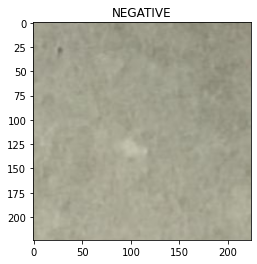

In [23]:
def show_img(img_arr, classname=None):
    img = np.transpose(img_arr.numpy(), (1, 2, 0))
    mean = np.array(IMAGENET_DEFAULT_MEAN)
    std = np.array(IMAGENET_DEFAULT_STD)
    img = img*std+mean
    plt.imshow(img)
    if classname!=None:
        title = "POSITIVE" if classname==1 else "NEGATIVE"
        plt.title(title)

show_img(inputs[0], classes[0])

## Create model

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [25]:
resnet50 = models.resnet50(pretrained=True)
resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
summary(resnet50, inputs[0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### Train model

In [27]:
idx_to_class = {0:'NEGATIVE', 1: 'POSITIVE'}
TRAIN_SIZE = len(dataset_train)
VAL_SIZE = len(dataset_val)

In [28]:
dataloaders = {'train': dataloder_train, 'val': dataloader_val}
dataset_sizes = {'train':TRAIN_SIZE, 'val':VAL_SIZE}

In [29]:
criterion = nn.CrossEntropyLoss() # Which loss?
optimizer = torch.optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

In [30]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [31]:
def train(model, epochs, dataloaders, dataset_sizes, optimizer, criterion, scheduler):
    losses, accuracies  = {'train':[], 'val':[]}, {'train':[], 'val':[]}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(epochs):
        print(f"Starting epoch {epoch}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            print("hello")
            print(100/dataset_sizes[phase]*BATCH_SIZE*1)
            for i, data in enumerate(dataloaders[phase],0):
                print("Still ok")
                inputs, classes = data
                # Print loading bar
                sys.stdout.write('\r')
                # the exact output you're looking for:
                sys.stdout.write("Epoch: %d %s:[%-20s] %f%%" % (epoch, phase, '='*i, 100/dataset_sizes[phase]*BATCH_SIZE*i))
                sys.stdout.flush()

                inputs, classes = inputs.to(device), classes.to(device)

                optimizer.zero_grad() # Set gradient to zero
                with torch.set_grad_enabled(phase == 'train'):
                    # Train model
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, classes)
                    

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == classes.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)

    return model, best_acc, losses, accuracies

In [32]:
model, best_acc, losses, accuracies = train(resnet50, 5, dataloaders, dataset_sizes, optimizer, criterion, scheduler)

Starting epoch 0
hello
0.0035714285714285713
Still ok
Epoch: 0 train:[                    ] 0.000000%

In [ ]:
torch.save(model, 'models/resnet50_25/11_kl2300.pth')

In [ ]:
type(losses)

dict

In [ ]:
with open('models/models/resnet50_25/11_kl2300.txt', 'w') as f:
    s = f"best acc: {str(best_acc)}, losses: {str(losses)}, accuracy: {str(accuracies)}"
    print(type(s))
    f.write(s)

<class 'str'>


In [ ]:
import sys
from time import sleep

In [ ]:
for i in range(21):
    sys.stdout.write('\r')
    # the exact output you're looking for:
    sys.stdout.write("[%-20s] %d%%" % ('='*i, 100/21*i))
    sys.stdout.flush()
    sleep(0.35)

[====================] 95%